In [1]:
import os
import tensorflow as tf

In [2]:
# Just checking if the GPUs are being detected

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Model training

In [3]:
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

In [4]:
# Just checking if there are any errors in the images dataset

data_dir = 'LeopardVsTiger' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('There is some issue with image {}'.format(image_path))

In [5]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 380 files belonging to 2 classes.


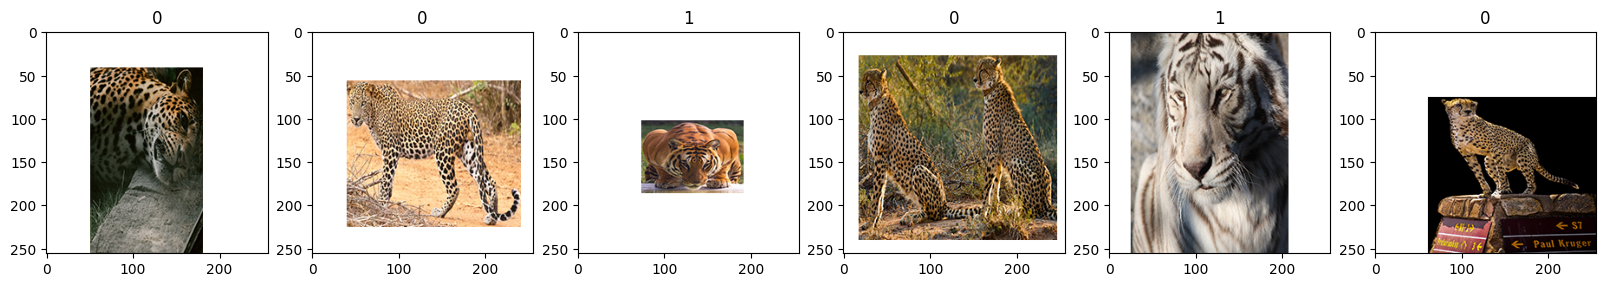

In [6]:
# 0 is for leopard, and 1 is for Tiger

data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=6, figsize=(20,20))
for idx, img in enumerate(batch[0][:6]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()
data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [9]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [10]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [12]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [13]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15


8/8 [==============================] - 12s 545ms/step - loss: 1.3499 - accuracy: 0.4570 - val_loss: 0.6949 - val_accuracy: 0.4375
Epoch 2/15
8/8 [==============================] - 1s 157ms/step - loss: 0.6926 - accuracy: 0.4961 - val_loss: 0.6918 - val_accuracy: 0.5938
Epoch 3/15
8/8 [==============================] - 1s 136ms/step - loss: 0.6872 - accuracy: 0.5820 - val_loss: 0.6799 - val_accuracy: 0.5469
Epoch 4/15
8/8 [==============================] - 1s 142ms/step - loss: 0.6678 - accuracy: 0.6172 - val_loss: 0.6196 - val_accuracy: 0.6562
Epoch 5/15
8/8 [==============================] - 1s 143ms/step - loss: 0.6266 - accuracy: 0.6367 - val_loss: 0.5998 - val_accuracy: 0.6562
Epoch 6/15
8/8 [==============================] - 1s 132ms/step - loss: 0.5334 - accuracy: 0.7461 - val_loss: 0.4027 - val_accuracy: 0.8438
Epoch 7/15
8/8 [==============================] - 1s 148ms/step - loss: 0.5046 - accuracy: 0.7773 - val_loss: 0.8156 - val_accuracy: 0.5938
Epoch 8/15
8/8 [==============

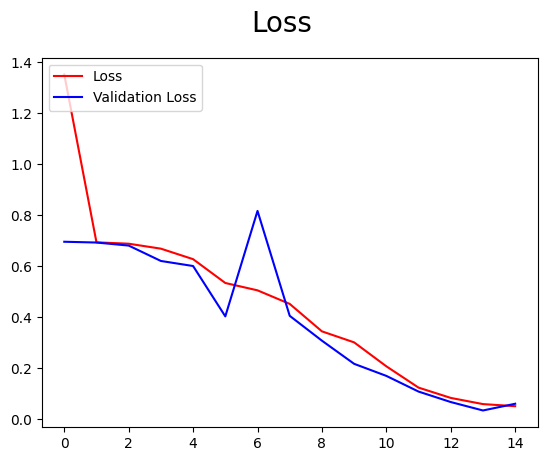

In [14]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='Loss')
plt.plot(hist.history['val_loss'], color='blue', label='Validation Loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

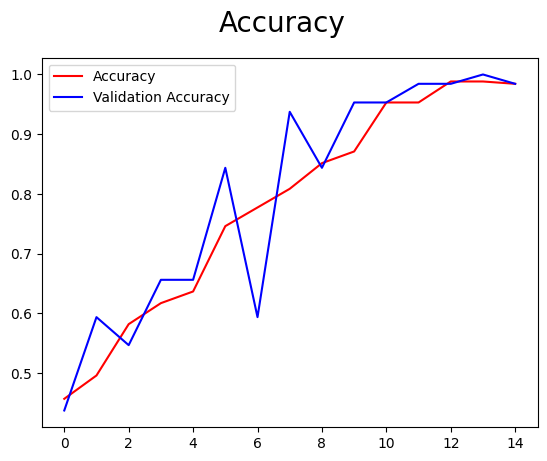

In [15]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='red', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='Validation Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [16]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [17]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    predictions = model.predict(X)
    pre.update_state(y, predictions)
    re.update_state(y, predictions)
    acc.update_state(y, predictions)

In [18]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


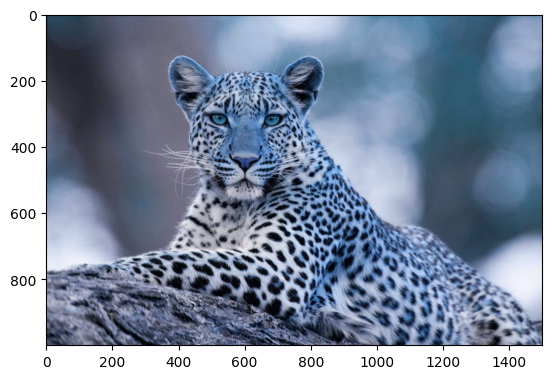

In [19]:
img = cv2.imread('leopard.jpg')
plt.imshow(img)
plt.show()

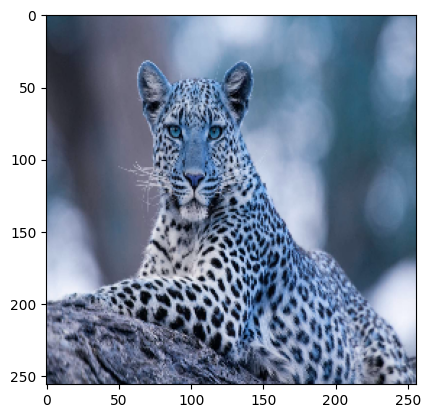

In [20]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [21]:
predictions = model.predict(np.expand_dims(resize/255, 0))

In [22]:
if predictions > 0.5: 
    print(f'Predicted class is Tiger') #Since 1 is for Tiger
else:
    print(f'Predicted class is Leopard') # Since 0 is for leopard

Predicted class is Leopard


In [23]:
predictions

array([[0.00116535]], dtype=float32)

In [24]:
model.save(os.path.join('savedModels','leopardVsTiger.h5'))

In [25]:
new_model = load_model(os.path.join('savedModels','leopardVsTiger.h5'))
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.00116535]], dtype=float32)